In [49]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from math import sqrt

In [50]:
class SLR():
    '''
    
    Class for implamintation of Simple Linear Regression (SLR)

    '''
    def __init__(self):
        '''
        
        Class constructor

        Attributes:
            PATH_TO_DATASET [str]: relative path to data with positive relation
            PATH_DO_NEGATIVE_DATASET [str]: relative path to data with positive relation
            _dataset [pd.DataFrame]: dataframe with positive relations dataset
            _negative_dataset [pd.DataFrame]: dataframe with negative relations dataset
            _solv [pd.DataFrame]: dataframe with experiments output
             
        '''
        self.PATH_TO_DATASET = 'dataset/flats_moscow.csv'
        self._dataset= pd.DataFrame()
        self._solv = pd.DataFrame(columns=['cnt', 'Real Y', 'Predict Y', 'B1', 'B2', 'Sum of E', 'R'])


    def StoringDataSet(self)->None:
        '''
        
        Storing dataset from csv to DataFrame and choosing only important data(price and area)

        '''
        path = Path(self.PATH_TO_DATASET)
        
        if not path.is_file():  # check is file with dataset exist
            raise Exception(f'Error! File with dataset on path {self.PATH_TO_DATASET} is not exist')
        
        self._dataset= pd.read_csv(self.PATH_TO_DATASET)  # store dataset to dataframe
        
        if self._dataset.empty:  # check is dataframe not empty
            raise Exception(f'Waring! Data set on path {self.PATH_TO_DATASET} is empty. Counting is aborted.')
        
        self._is_stored_dataset = True


    def _Check_dataset(self)->bool:
        '''

        Description:
            Datasets should not be empty
        
        '''
        if self._dataset.empty:
            return False

        return True

    def _Get_dataset(self, positive:bool)->pd.DataFrame:
        '''
        
        Description: 
            Give dataset for experiment

        '''
        return self._dataset

    def _Sampling(self, data:pd.DataFrame, full_dataset:bool, random_sampling:bool, cnt_sample:int)->tuple[np.array, np.array]:
        '''
        Description:
            Datasets sampling

        Parametrs:
            data [pd.DataFrame]: dataframe to sampling
            full_dataset [bool]: work with all data or sample
            random_sampling [bool]: sample with random number of items from diaposon [20, 100]
            cnt_sample  [bool]: items number in sample

        '''
        sample = data.loc[:, ['price', 'totsp']]
        
        if random_sampling:
            cnt_samples = np.random.randint(20, 100)
        else:
            cnt_samples = cnt_sample
        
        if not full_dataset:
            try:
                sample = sample.sample(n=cnt_samples)
            except ValueError as e:
                raise Exception("Warning! Requested count of items in sample more than have dataset on actual data range.")
        
        return sample['totsp'].values, sample['price'].values

    def _Vizualization(self, x:np.array, y:np.array, y_predict:np.array, e:np.array, with_err:bool)->None:
        '''
        
        Description:
            Experiments vizualization by plot

        Parametrs:
            x [np.array]: independent data
            y [np.array]: original dependent data
            y_predict [np.array]: prdicted dependet data
        
        '''
        plt.scatter(x, y, marker='o', color='blue')  # original relation

        plt.axis([x.min()-10, x.max()+10, y.min()-10, y.max()+10])
        
        plt.plot(x, y_predict, color='red')  # prediction

        if with_err:
            point = 0
            for x_it, y_it, y_pr_it, e_it in np.nditer([x, y, y_predict, e]):
                point += 1
                print(f'Point {point}: y_original={y_it}, y_predict={y_pr_it}, error={e_it}')
                plt.plot([x_it, x_it], [y_pr_it, y_pr_it+e_it], color='green')

        plt.xlabel('area ( m^2)')
        plt.ylabel('cost (1000 $)')
        plt.title('Area vs cost')
        
        plt.show()

        
    def _Alg(self, x:np.array, y:np.array)->tuple[np.array, int, float, int, int, np.array, float, float]:
        '''

        Description:
            Core of SLR
        
        Attributes:
            x [np.array]: independent data
            y [np.array]: dependent data

        '''

        x_mean = np.mean(x)
        y_mean = np.mean(y)
        
        b2 = np.sum(np.multiply((x - x_mean), (y - y_mean)))/np.sum(np.power((x - x_mean), 2))
        b1 = y_mean - b2*x_mean

        y_predict = b1 + b2*x

        e = y - y_predict  # positive (up), negative (down)

        e_sum = np.sum(e)
        y_sum = np.sum(y)
        y_predict_sum = np.sum(y_predict)

        r = (np.mean(np.multiply(x, y)) - np.mean(x)*np.mean(y))/sqrt((np.mean(np.power(x,2))-np.mean(x)**2)*(np.mean(np.power(y,2))-np.mean(y)**2))

        return y_predict, y_sum, y_predict_sum, b1, b2, e, e_sum, r
        

    def Experiment(self, count:int, full_dataset:bool, random_sampling:bool, positive:bool, cnt_sample:int, viz_with_err:bool)->None:
        
        '''
        Description:
            Experiment process.
            Based on input sample, find B1, B2 and count probability Y

        Parametrs:
            count [int]: number of repetitions
            full_dataset [bool]: work with all data or sample
            random_sampling [bool]: sample with random number of items from diaposon [20, 100]
            positive [bool]: data from dataset with positive/negative relation
            cnt_sample [int]: items number in sample

        '''
        self._solv.drop(self._solv.index,inplace=True)
        
        if count < 0:  # check count of repetitions
            raise Exception('Warning! The range of the number of elements must be greater than zero.')

        if full_dataset:  # one experiment for full dataset
            count = 1

        if not self._Check_dataset():  # check data storing
            raise Exception('Warning! You have empty datasets. Please store a data')
        
        for _ in range(count):  # repetitions

            x, y, = self._Sampling(self._Get_dataset(positive), full_dataset, random_sampling, cnt_sample)  # independent(x) and dependent(y) data 
            
            y_predict, y_sum, y_predict_sum, b1, b2, e, e_sum, r = self._Alg(x, y)  # SLR
            
            self._solv.loc[len(self._solv)] = {'cnt':x.size, 'Real Y':y_sum, 'Predict Y':y_predict_sum, 'B1': b1, 'B2': b2, 'Sum of E':e_sum, 'R': r}   # store output of actual expiriment
            
            if count == 1:  # vizual for only one experiment
                self._Vizualization(x, y, y_predict, e, viz_with_err)


        print(self._solv)

    

In [51]:
# Prepare data

SLR_solv = SLR()
SLR_solv.StoringDataSet()


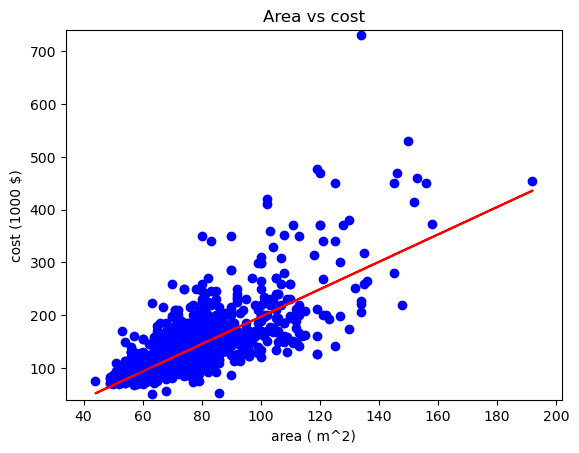

    cnt  Real Y  Predict Y         B1        B2      Sum of E         R
0  2040  260093   260093.0 -62.044844  2.593462 -5.042011e-11  0.756042


In [52]:
# Experiment № 1
# Description: SLR with full dataset (positive relation)

SLR_solv.Experiment(count=1, full_dataset=True, random_sampling=False, positive=False, cnt_sample=0, viz_with_err=False)

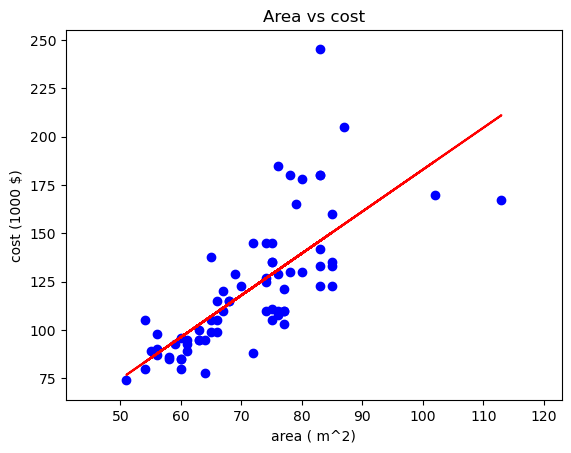

   cnt  Real Y  Predict Y         B1        B2      Sum of E         R
0   71    8572     8572.0 -33.541681  2.164288 -1.278977e-13  0.731794


In [53]:
# Experiment № 2
# Description: SLR with datasets sample (positive relation)

SLR_solv.Experiment(count=1, full_dataset=False, random_sampling=True, positive=False, cnt_sample=0, viz_with_err=False)

Point 0: y_original=103, y_predict=126.40694149742345, error=-23.406941497423446
Point 0: y_original=80, y_predict=82.31357987268868, error=-2.3135798726886776
Point 0: y_original=230, y_predict=184.27947862988788, error=45.720521370112124
Point 0: y_original=120, y_predict=142.94195210669898, error=-22.941952106698977
Point 0: y_original=108, y_predict=131.9186117005153, error=-23.9186117005153
Point 0: y_original=85, y_predict=90.58108517732643, error=-5.581085177326429
Point 0: y_original=159, y_predict=145.6977872082449, error=13.302212791755096
Point 0: y_original=145, y_predict=131.9186117005153, error=13.0813882994847
Point 0: y_original=120, y_predict=85.06941497423458, error=34.930585025765424
Point 0: y_original=162, y_predict=170.50030312215824, error=-8.500303122158243
Point 0: y_original=73, y_predict=71.29023946650497, error=1.7097605334950288
Point 0: y_original=170, y_predict=159.47696271597454, error=10.523037284025463
Point 0: y_original=125, y_predict=137.43028190360

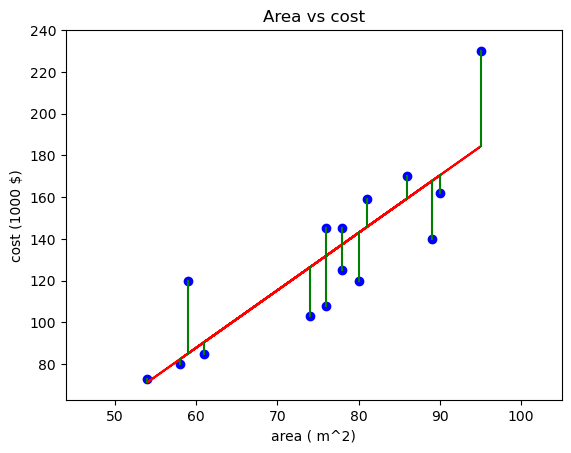

   cnt  Real Y  Predict Y         B1        B2      Sum of E         R
0   15    1965     1965.0 -77.524856  2.755835  1.421085e-13  0.848286


In [54]:
# Experiment № 3
# Description: SLR with datasets sample (positive relation)

SLR_solv.Experiment(count=1, full_dataset=False, random_sampling=False, positive=False, cnt_sample=15,  viz_with_err=True)